In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from DecoderTrans import TransformerDecoder
from tokenizer import CurriculumTokenizer
from torch.nn.utils.rnn import pad_sequence
%matplotlib inline

In [2]:
# Загружаем данные
df = pd.read_csv('сurriculum_data.csv')

# Разделение на тренировочный и тестовый наборы
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Определение классов для работы с данными
class ExpressionDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.tokenizer = CurriculumTokenizer()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        expression = row['expression']
        result = row['result']

        # Преобразуем метку, вычитая минимальное значение метки
        result -= self.df['result'].min()  # Это приводит все метки к диапазону от 0 до N-1

        encoded_expression = self.tokenizer.encode(expression)
        return encoded_expression, result


# Создание объектов Dataset
train_dataset = ExpressionDataset(train_df)
val_dataset = ExpressionDataset(val_df)


def collate_batch(batch):
    expressions, results = zip(*batch)

    # Преобразуем каждое выражение в тензор
    expressions = [torch.tensor(expr) for expr in expressions]

    # Получаем длину каждого выражения
    lengths = [len(expr) for expr in expressions]

    # Паддим выражения
    padded_expressions = pad_sequence(expressions, batch_first=True, padding_value=0)

    # Преобразуем результаты в тензор
    results_tensor = torch.LongTensor(results)  # Тензор меток

    return padded_expressions, lengths, results_tensor



# Создание DataLoader с использованием функции collate_batch
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

In [3]:
for batch in train_loader:
    print(batch)  # Печатаем весь batch, чтобы понять его структуру
    break  # Просто выводим первый батч, чтобы не выводить всё

def collate_batch(batch):
    expressions, results = zip(*batch)  # Разделяем выражения и результаты

    # Преобразуем каждое выражение в тензор
    expressions = [torch.tensor(expr) for expr in expressions]

    # Получаем длину каждого выражения
    lengths = [len(expr) for expr in expressions]  # Это можно использовать, если нужно

    # Паддим выражения
    padded_expressions = pad_sequence(expressions, batch_first=True, padding_value=0)

    # Преобразуем результаты в тензор
    results_tensor = torch.LongTensor(results)  # Тензор меток

    return padded_expressions, results_tensor

# Создаем DataLoader с collate_fn
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)


(tensor([[ 1, 12, 10,  7, 12,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  3, 12, 13,  4, 15, 11,  3,  6,  3, 13, 14,  5, 12, 12,  3,  2],
        [ 1, 14, 17,  4, 15, 18,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 18, 19,  6, 13, 11,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 16, 11,  6, 16, 19,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 16, 14,  5, 13, 13,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  3, 11, 18,  4, 17, 14,  3,  6,  3, 16, 19,  5, 12, 10,  3,  2],
        [ 1, 18, 13,  7, 12,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 12, 13,  6, 14, 11,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 18, 16,  6, 15, 12,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 12, 16,  6, 16, 19,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 19, 13,  5, 12, 13,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 11, 12,  4, 18, 13,  2,  0,  0,  0,  0,  0,  0,  0

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = DecoderTransformer(num_tokens=20, n_embd=128, num_layers=6, num_heads=8, num_classes=10).to(device)
num_classes = df['result'].max() - df['result'].min() + 1  # Подсчитываем количество классов
model = TransformerDecoder(num_tokens=20, n_embd=128, num_layers=6, num_heads=8, num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [8]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc="Training")
    for inputs, targets in pbar:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # [batch_size, seq_len, num_classes]

        # Выбираем выход для последнего токена
        outputs = outputs[:, -1, :]  # [batch_size, num_classes]

        # Вычисляем потери
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        pbar.set_postfix(loss=loss.item())

    accuracy = 100 * correct / total
    epoch_loss = total_loss / len(loader)
    return epoch_loss, accuracy


In [13]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(loader, desc="Evaluating")
        for inputs, _, targets in pbar:  # Добавляем "_" для lengths, если они не используются
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)  # [batch_size, seq_len, num_classes]

            # Извлекаем выход для последнего токена
            outputs = outputs[:, -1, :]  # [batch_size, num_classes]

            # Вычисляем потери
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # Предсказания
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            pbar.set_postfix(loss=loss.item())

    accuracy = 100 * correct / total
    epoch_loss = total_loss / len(loader)
    return epoch_loss, accuracy


In [14]:
epochs = 10
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 5.3926, Train Acc: 12.37%
Val Loss: 6.3649, Val Acc: 13.19%

Epoch 2/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 5.1233, Train Acc: 13.21%
Val Loss: 6.3469, Val Acc: 16.48%

Epoch 3/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 4.8068, Train Acc: 18.70%
Val Loss: 6.2205, Val Acc: 22.18%

Epoch 4/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 4.4124, Train Acc: 23.12%
Val Loss: 6.1504, Val Acc: 22.94%

Epoch 5/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 4.0948, Train Acc: 24.13%
Val Loss: 6.2872, Val Acc: 24.59%

Epoch 6/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 3.8001, Train Acc: 26.45%
Val Loss: 6.2932, Val Acc: 25.21%

Epoch 7/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 3.5457, Train Acc: 28.00%
Val Loss: 6.4710, Val Acc: 26.24%

Epoch 8/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 3.3015, Train Acc: 29.99%
Val Loss: 6.4178, Val Acc: 27.54%

Epoch 9/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 3.0675, Train Acc: 31.74%
Val Loss: 6.5644, Val Acc: 27.61%

Epoch 10/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 2.8512, Train Acc: 32.96%
Val Loss: 6.5425, Val Acc: 28.85%


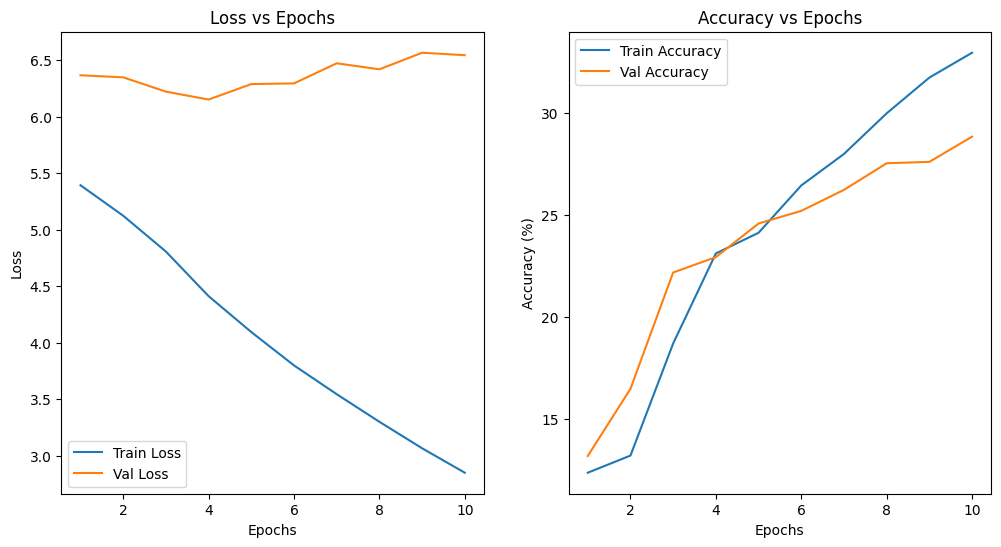

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.subplot(122)
plt.plot(range(1, epochs+1), train_accs, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accs, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.show()


Random Sampling Epoch 1/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 2.6346, Train Acc: 36.09%
Val Loss: 6.5126, Val Acc: 28.98%

Random Sampling Epoch 2/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 2.4313, Train Acc: 38.90%
Val Loss: 6.5984, Val Acc: 30.01%

Random Sampling Epoch 3/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 2.2422, Train Acc: 42.25%
Val Loss: 6.8811, Val Acc: 29.67%

Random Sampling Epoch 4/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 2.0667, Train Acc: 44.54%
Val Loss: 7.0728, Val Acc: 30.43%

Random Sampling Epoch 5/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 1.8874, Train Acc: 48.13%
Val Loss: 7.0735, Val Acc: 32.01%

Random Sampling Epoch 6/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 1.7438, Train Acc: 51.39%
Val Loss: 7.1479, Val Acc: 31.04%

Random Sampling Epoch 7/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 1.5934, Train Acc: 54.57%
Val Loss: 7.2898, Val Acc: 32.49%

Random Sampling Epoch 8/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 1.4673, Train Acc: 56.97%
Val Loss: 7.3302, Val Acc: 33.17%

Random Sampling Epoch 9/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 1.3543, Train Acc: 60.41%
Val Loss: 7.5450, Val Acc: 32.62%

Random Sampling Epoch 10/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 1.2385, Train Acc: 63.35%
Val Loss: 7.6710, Val Acc: 32.35%

Curriculum Learning Epoch 1/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 1.1034, Train Acc: 66.94%
Val Loss: 7.7336, Val Acc: 33.17%

Curriculum Learning Epoch 2/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 1.0524, Train Acc: 69.10%
Val Loss: 7.9708, Val Acc: 32.69%

Curriculum Learning Epoch 3/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 0.9973, Train Acc: 70.13%
Val Loss: 8.0683, Val Acc: 33.24%

Curriculum Learning Epoch 4/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 0.8890, Train Acc: 73.41%
Val Loss: 8.0606, Val Acc: 33.79%

Curriculum Learning Epoch 5/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 0.8465, Train Acc: 75.30%
Val Loss: 8.1190, Val Acc: 33.24%

Curriculum Learning Epoch 6/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 0.7516, Train Acc: 77.67%
Val Loss: 8.1667, Val Acc: 34.20%

Curriculum Learning Epoch 7/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 0.6875, Train Acc: 79.82%
Val Loss: 8.1856, Val Acc: 34.00%

Curriculum Learning Epoch 8/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 0.6419, Train Acc: 81.16%
Val Loss: 8.3791, Val Acc: 33.86%

Curriculum Learning Epoch 9/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 0.6303, Train Acc: 81.04%
Val Loss: 8.4505, Val Acc: 33.93%

Curriculum Learning Epoch 10/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 0.6158, Train Acc: 81.52%
Val Loss: 8.7076, Val Acc: 34.20%


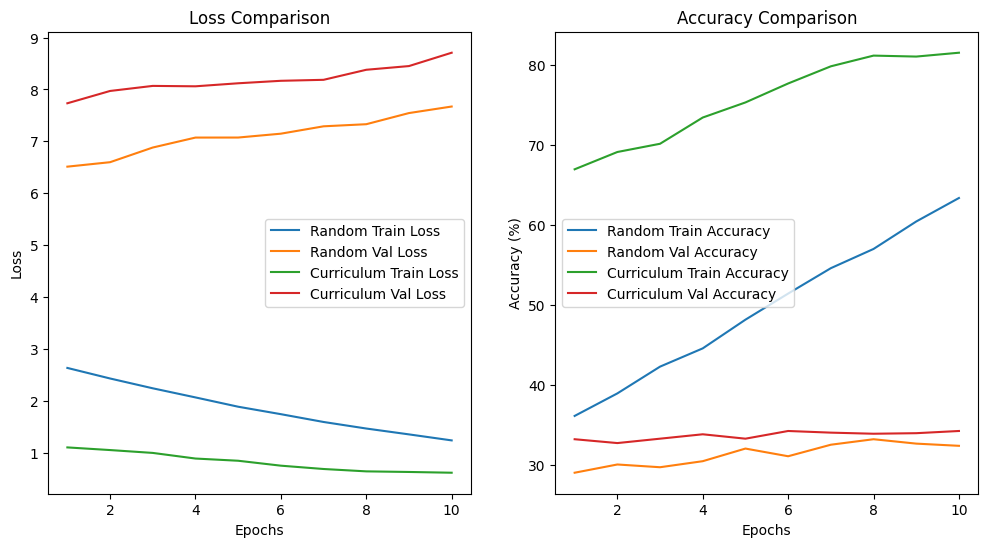

In [16]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Случайное сэмплирование (обучение с случайным сэмплированием)
def train_random_sampling():
    random_train_losses, random_val_losses = [], []
    random_train_accs, random_val_accs = [], []

    for epoch in range(epochs):
        print(f"\nRandom Sampling Epoch {epoch+1}/{epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        random_train_losses.append(train_loss)
        random_train_accs.append(train_acc)
        random_val_losses.append(val_loss)
        random_val_accs.append(val_acc)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return random_train_losses, random_val_losses, random_train_accs, random_val_accs

# Curriculum learning (обучение с curriculum learning)
def train_curriculum_learning():
    # Используем измененный порядок данных
    curriculum_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

    curriculum_train_losses, curriculum_val_losses = [], []
    curriculum_train_accs, curriculum_val_accs = [], []

    for epoch in range(epochs):
        print(f"\nCurriculum Learning Epoch {epoch+1}/{epochs}")
        train_loss, train_acc = train_epoch(model, curriculum_train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        curriculum_train_losses.append(train_loss)
        curriculum_train_accs.append(train_acc)
        curriculum_val_losses.append(val_loss)
        curriculum_val_accs.append(val_acc)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return curriculum_train_losses, curriculum_val_losses, curriculum_train_accs, curriculum_val_accs

# Запуск экспериментов
random_train_losses, random_val_losses, random_train_accs, random_val_accs = train_random_sampling()
curriculum_train_losses, curriculum_val_losses, curriculum_train_accs, curriculum_val_accs = train_curriculum_learning()

# Визуализация потерь
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(range(1, epochs+1), random_train_losses, label='Random Train Loss')
plt.plot(range(1, epochs+1), random_val_losses, label='Random Val Loss')
plt.plot(range(1, epochs+1), curriculum_train_losses, label='Curriculum Train Loss')
plt.plot(range(1, epochs+1), curriculum_val_losses, label='Curriculum Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Comparison')

# Визуализация точности
plt.subplot(122)
plt.plot(range(1, epochs+1), random_train_accs, label='Random Train Accuracy')
plt.plot(range(1, epochs+1), random_val_accs, label='Random Val Accuracy')
plt.plot(range(1, epochs+1), curriculum_train_accs, label='Curriculum Train Accuracy')
plt.plot(range(1, epochs+1), curriculum_val_accs, label='Curriculum Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Comparison')

plt.show()
